# Deeper CNN with Image Augmentation (Modeling)

The below was ran on a Google Cloud instance with 16 vCPUs, 104 GB memory, and 2 NVIDIA Tesla K80 GPUs using an image provided by Stanford's CS231n course (cs231n-files/cs231n_image.tar.gz)

### Load libraries & data

In [1]:
import numpy as np
import pandas as pd
import pickle

import keras
from keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint

from ipywidgets import interact, fixed
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


### Data Setup

In [2]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='reflect')

test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
batch_size = 16

train_generator = train_datagen.flow_from_directory(
        '../data/datagen_modeling/train',  
        target_size=(72, 72),  
        batch_size=batch_size,
        class_mode='binary')  

validation_generator = test_datagen.flow_from_directory(
        '../data/datagen_modeling/validation',
        target_size=(72, 72),
        batch_size=batch_size,
        class_mode='binary')

Found 804 images belonging to 2 classes.
Found 189 images belonging to 2 classes.


### Model Architecture

In [4]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(72, 72, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 70, 70, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 70, 70, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 33, 33, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
__________

In [5]:
checkpoint = ModelCheckpoint("weights_best.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

class TrainingVisualizerCallback(keras.callbacks.History):
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        clear_output(wait=True)
        pd.DataFrame(self.history).plot()
        plt.show()        

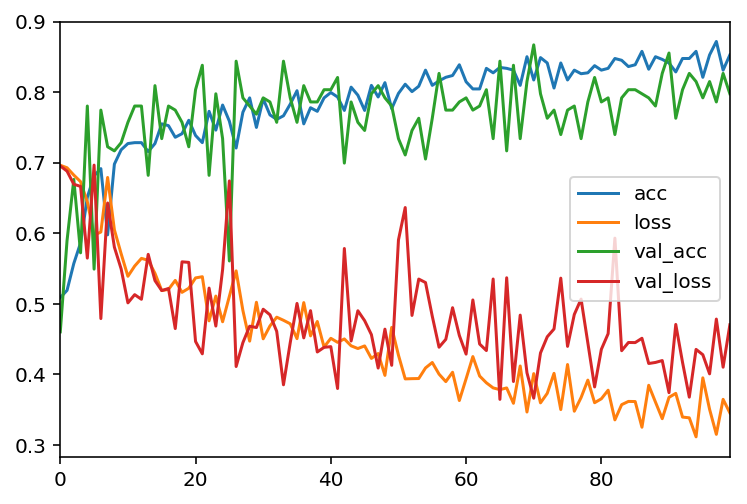

50/50 [==============================] - 3s - loss: 0.3458 - acc: 0.8513 - val_loss: 0.4702 - val_acc: 0.7977


In [6]:
final_model = model.fit_generator(
        train_generator,
        steps_per_epoch=804 // batch_size,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=189 // batch_size,
        callbacks=[checkpoint, TrainingVisualizerCallback()])

In [7]:
model_json = model.to_json()
with open("final_model.json", "w") as json_file:
    json_file.write(model_json)

In [8]:
history = final_model.history

file_Name = "model_history"
fileObject = open(file_Name,'wb') 

pickle.dump(history,fileObject)   

fileObject.close()